# Yelp Data Challenge - Clustering of Restaurants

Clustering allows us to discover topics and themes among reviews. Also, they may reveal to us some interesting patterns of attributes/distributions across restaurants. For instance, can we divide restaurants that received perfect ratings into several subclasses (clusters)? What makes these restaurants so great? 

We will utilize K-means clustering, and tune `K` the number of clusters using the elbow method.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('data/last_2_years_restaurant_reviews.csv')
df.head(3)

,business_id,name,categories,avg_stars,attributes,cool,date,funny,review_id,stars,text,useful,user_id
0,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2017-04-01,0,Spl0fx_X6bjPASU-zUJQUA,1,"Ordered a pizza, the location is literally in ...",1,vZ-eQzpCOrSWfBfU5KUvIA
1,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2016-11-20,0,2UV-a8pXUdbK0fdurFwXfQ,5,Very busy place but they take good care of you...,0,nu6wU6PLbL9HPLZuqon0-A
2,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2018-03-27,0,vG5m3TzOf5F52jzO2D_19g,3,Stopped here to pick up an order of wings on m...,0,KEerqlFNhzl1I-yVK6mHVA


## 1. Cluster the review text data for all restaurants

As a demonstration of technique, and as an attempt to discover themes trending among all reviewers

### Define feature variables

In [3]:
# Take the review texts and save to variable named 'documents'
# To be transformed into numerical vectors and clustered
documents = df.text

# Same target variable as in NLP.ipynb --- whether a review gives a 'perfect' rating (5)
target = (df.stars == 5).astype('int')

In [4]:
# Balanced classes
target.value_counts()

0    52978
1    48591
Name: stars, dtype: int64

### Withhold subset of data, for testing purposes
We can simulate the influx of new data by creating a held-out "test set". K-means clustering is of course unsupervised; we are just borrowing terminology from supervised methods.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# documents is your X, target is your y
# Now split the data to training set and test set
documents_train, documents_test, target_train, target_test = train_test_split(documents, target)

In [7]:
print(documents_train.shape, documents_test.shape, target_train.shape, target_test.shape)

(76176,) (25393,) (76176,) (25393,)


In [8]:
# Sanity check for splitting
print(documents.shape[0] == documents_train.shape[0] + documents_test.shape[0])

True


### Get NLP representation of the documents

Fit TfidfVectorizer with 'training' data only, then tranform all data to tf-idf

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

Create TfidfVectorizer, and name it `vectorizer`. Choose a reasonable `max_features`, e.g. 1000; in other words, we only keep the Tf-idf vectors of the most common 1000 words.

Must remove stop words this time, unlike in `NLP.ipynb`, because stop words may take up a large proportion of `max_features` when `max_features` is small.

In [10]:
stopwords_english = stopwords.words('english')
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords_english)

In [11]:
# Train the model with your training data
vectorizer.fit(documents_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
# Get the vocab of tfidf features
word_to_index = vectorizer.vocabulary_
index_to_word = {index:word for word,index in word_to_index.items()}

In [13]:
# Use the trained model to transform all the reviews
vec_documents_all = vectorizer.transform(documents)
vec_documents_train = vectorizer.transform(documents_train)

### Cluster reviews with KMeans
Fit k-means clustering with "training data", and then apply it on the entire data set. Tune with the elbow method.

In [14]:
# Using sklearn.cluster.MiniBatchKMeans instead of sklearn.cluster.KMeans
# Slightly worse clustering, but much faster convergence

from sklearn.cluster import MiniBatchKMeans

In [15]:
# Start with arbitrary K = 3
kmeans = MiniBatchKMeans(n_clusters=3, batch_size=500, max_iter=5000)
kmeans.fit(vec_documents_train)

MiniBatchKMeans(batch_size=500, compute_labels=True, init='k-means++',
        init_size=None, max_iter=5000, max_no_improvement=10, n_clusters=3,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [16]:
cluster_assignments = kmeans.predict(vec_documents_all)

#### Inspect the centroids
To find out what "topics" Kmeans has discovered we must inspect the centroids. 

These centroids are simply a bunch of numerical vectors. To make sense of these vectors we need to map them back into 'word space'. We can think of each feature/dimension of a centroid vector as representing the "average" review or the average occurances of words for that cluster.

In [17]:
# 1000, exactly like max_features
print(kmeans.cluster_centers_[0].shape)

# Since we're using Tf-idf features, all vector components are non-negative
for i,vector in enumerate(kmeans.cluster_centers_):
    print(f"Number of negative components in cluster {i}: {np.sum(vector<0.0)}")

(1000,)
Number of negative components in cluster 0: 0
Number of negative components in cluster 1: 0
Number of negative components in cluster 2: 0


#### Find the top *n* features for each cluster.
For topics we are only really interested in the most present words, i.e. features/dimensions with the greatest representation in the centroid.  Print out the top ten words for each centroid.

* Sort each centroid vector to find the top 10 features
* Go back to your vectorizer object to find out what words each of these features corresponds to.


In [18]:
'''
Several common themes emerged: 
comments on staff attitudes, service quality, and the taste of food. Nothing surprisingly here.
'''

def print_top_features(cluster_centers, ix_to_words, n=10):
    for i, centroid in enumerate(cluster_centers):
        top_n_features = np.argsort(centroid)[::-1]
        top_n_features = top_n_features[:n]
        top_n_words = [ix_to_words[feature_index] for feature_index in top_n_features]

        print("Top words from cluster {}".format(i))
        print(top_n_words)

print_top_features(kmeans.cluster_centers_, index_to_word, n=10)

Top words from cluster 0
['great', 'food', 'service', 'amazing', 'place', 'best', 'delicious', 'friendly', 'vegas', 'good']
Top words from cluster 1
['good', 'chicken', 'ordered', 'food', 'like', 'place', 'really', 'also', 'rice', 'delicious']
Top words from cluster 2
['food', 'place', 'pizza', 'time', 'get', 'good', 'one', 'order', 'go', 'service']


#### Try larger K's; tune with elbow method
For a higher number of clusters, we expect to see more refined/narrow "themes". To systematically find an optimal K, we utilize the elbow method, which is simple to interpret.

In [19]:
'''
Arbitarily tried K = 6. Basically the same themes, but with more specific food items mentioned, 
e.g. thai food, sushi, and burgers and pizza crust. It would be interesting to see if 
they are actually more (un)popular among the reviewers.
'''

kmeans_6 = MiniBatchKMeans(n_clusters=6, batch_size=500, max_iter=5000)
kmeans_6.fit(vec_documents_train)
print_top_features(kmeans_6.cluster_centers_, index_to_word)

Top words from cluster 0
['amazing', 'best', 'food', 'vegas', 'place', 'love', 'delicious', 'service', 'ever', 'back']
Top words from cluster 1
['great', 'food', 'service', 'place', 'good', 'friendly', 'back', 'definitely', 'delicious', 'excellent']
Top words from cluster 2
['good', 'food', 'place', 'really', 'service', 'nice', 'like', 'buffet', 'get', 'go']
Top words from cluster 3
['order', 'food', 'us', 'time', 'like', 'ordered', 'one', 'get', 'would', 'got']
Top words from cluster 4
['pizza', 'crust', 'good', 'place', 'great', 'cheese', 'service', 'ordered', 'best', 'pepperoni']
Top words from cluster 5
['pho', 'ramen', 'pork', 'broth', 'thai', 'rice', 'good', 'place', 'noodles', 'spicy']


In [20]:
from elbow import elbow_tuner

'''
    Perform elbow tuning for k-means clustering

    Input:
        data: MxN matrix --- M observations of N features 
        k_to_try: (1D) iterable containing values of K to try

    Return:
        intra_cluster_ss: 1D array containing averaged intra-cluster sum-of-squares, for each K
'''

In [22]:
within_cluster_ss = elbow_tuner(vec_documents_all, range(3,40))

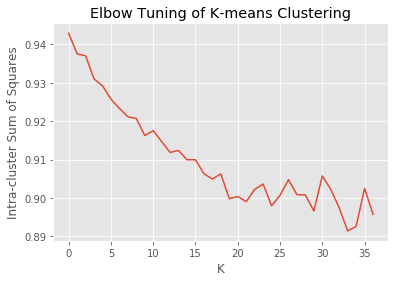

In [23]:
# The elbow is around K = 20-25. Let's experiment with 20
plt.title("Elbow Tuning of K-means Clustering")
plt.xlabel("K")
plt.ylabel("Intra-cluster Sum of Squares")
plt.plot(within_cluster_ss, "-")

In [73]:
kmeans_20 = MiniBatchKMeans(n_clusters=20, random_state=90)
kmeans_20.fit(vec_documents_all)
print_top_features(kmeans_20.cluster_centers_, index_to_word, n=10)

Top words from cluster 0
['sushi', 'place', 'roll', 'good', 'great', 'rolls', 'fresh', 'fish', 'service', 'ayce']
Top words from cluster 1
['tacos', 'taco', 'asada', 'carne', 'good', 'food', 'place', 'mexican', 'vegas', 'burrito']
Top words from cluster 2
['thai', 'curry', 'pad', 'food', 'good', 'place', 'chicken', 'rice', 'spicy', 'restaurant']
Top words from cluster 3
['great', 'food', 'service', 'place', 'good', 'atmosphere', 'awesome', 'staff', 'best', 'friendly']
Top words from cluster 4
['ramen', 'pork', 'broth', 'noodles', 'place', 'belly', 'good', 'spicy', 'miso', 'bowl']
Top words from cluster 5
['korean', 'speak', 'combo', 'hands', 'style', 'ask', 'enough', 'cooked', 'fried', 'rice']
Top words from cluster 6
['highly', 'recommend', 'food', 'place', 'great', 'service', 'amazing', 'delicious', 'would', 'best']
Top words from cluster 7
['chicken', 'good', 'food', 'fried', 'rice', 'ordered', 'place', 'salad', 'like', 'great']
Top words from cluster 8
['breakfast', 'eggs', 'pancak

#### How many reviews are there in each cluster?
Goal: inspect whether there are clusters with only a few reviews. They may encode rare words and information ... or it's an anomaly hard to interpret. 

After brief experimentation with different random seeds (84, 85, 90), small clusters persisted, even though they contain different sets of reviews for each different seed. Will proceed as is for now.

In [70]:
pd.Series(kmeans_20.labels_).value_counts()

13    26252
15    10643
18     8962
3      7178
16     6588
14     6356
7      5629
10     4961
0      3440
9      3367
8      3272
6      3072
1      2258
12     2168
2      2080
11     2018
4      1975
19     1338
5        11
17        1
dtype: int64

#### The star rating in each cluster
Print mean and median star rating of each cluster; see if each cluster encode a different value. Interestingly, for the **vast majority** of clusters the median is larger than the mean. That is *consistent* with `Preprocessing.ipynb`, where it is observed the number of reviews at each rating is right-skewed, i.e. towards higher ratings. The median review may have a high rating, but the overall mean is dragged down by the short-tail with low ratings.

The only exception is cluster 18, whose mean and median are also much lower than those of other clusters. For those interested in studying bad restaurants, that is the go-to cluster!

In [71]:
for cid in range( len(kmeans_20.cluster_centers_) ):
    # for each cluster ID
    mask = (kmeans_20.labels_ == cid)
    avg_star = np.mean(df.stars[mask])
    median_star = np.median(df.stars[mask])
    print("Mean/Median rating @ cluster {}: {:2f}/{:2f}".format(cid, avg_star, median_star))

Mean/Median rating @ cluster 0: 4.193314/5.000000
Mean/Median rating @ cluster 1: 3.911869/5.000000
Mean/Median rating @ cluster 2: 4.187019/5.000000
Mean/Median rating @ cluster 3: 4.623433/5.000000
Mean/Median rating @ cluster 4: 4.154937/5.000000
Mean/Median rating @ cluster 5: 3.818182/4.000000
Mean/Median rating @ cluster 6: 4.707357/5.000000
Mean/Median rating @ cluster 7: 3.760526/4.000000
Mean/Median rating @ cluster 8: 3.963631/4.000000
Mean/Median rating @ cluster 9: 3.708346/4.000000
Mean/Median rating @ cluster 10: 3.852651/4.000000
Mean/Median rating @ cluster 11: 3.991080/5.000000
Mean/Median rating @ cluster 12: 3.995387/4.000000
Mean/Median rating @ cluster 13: 3.705318/4.000000
Mean/Median rating @ cluster 14: 4.715072/5.000000
Mean/Median rating @ cluster 15: 3.284224/4.000000
Mean/Median rating @ cluster 16: 4.624013/5.000000
Mean/Median rating @ cluster 17: 5.000000/5.000000
Mean/Median rating @ cluster 18: 1.798817/1.000000
Mean/Median rating @ cluster 19: 3.968610

To wrap up this study of reviews overall, let's look at a sample review from each cluster. That should consolidate our sense of what each cluster represents.

In [52]:
for cid in range( len(kmeans_20.cluster_centers_) ):
    # Get boolean mask for reviews corresponding to each cid
    mask = (kmeans_20.labels_ == cid)
    
    # Obtain star ratings corresponding to reviews in cluster 'cid'
    stars = df.stars[ mask ]
    
    # Obtain the first review for each cid (an arbitary choice)
    review_index = np.nonzero(mask)[0][0]
    star = stars[review_index]
    
    print("\nSample review from cluster {}, rating {}".format(cid, star))
    print(documents[review_index])


Sample review from cluster 0, rating 5
Just replaced I Love Sushi in Henderson as our favorite sushi den. Small, cozy atmosphere with awesome food. Don't go there without getting the Avocado Treasure Chest.

Sample review from cluster 1, rating 1
This is the second location and they have No TACOS AT ALL... lol it's almost funny at this point because the woman says "I will have them tomorrow"  how does that help me at the moment?!?!? El Pollo Loco is a JOKE

Sample review from cluster 2, rating 5
the food is close to perfection...tempura udon is the best  ingredients are fresh,combined with thai tea...that's awesome  oishi!!!

Sample review from cluster 3, rating 5
Very busy place but they take good care of you right away w/ GREAT customer service.  Terra is quick and greets everyone !

Sample review from cluster 4, rating 4
Best  ramen ive had in vegas so far, after going through quite a few places this place is our favorite yet! Staff is very polite and always greets us as we walk in

### Conclusion from Clustering All Reviews

Having looked at the top 10 words from each of the 20 clusters, here are some business observations and pointers for further investigation:

1. Many of the clusters are associated with a specific cusine or dish --- from sushi, ramen, salad, curry to steaks and 'spicy' food. Therefore, we can discover the most discussed/reviewed categories of foods, in Las Vegas in this case.

2. The clusters also help us identify the factors leading a positive dining experience. In addition to 'delicious' food, apparently 'friendly (staff)', 'service' and 'atmosphere' also matter. Even though in hindsight that is not surprising, the reviews (and their clusters) serve as empirical evidence that customers do care about these things.

3. On the other hand, we can identity (from cluster 18) how restaurants can receive the worst rating from customers. The sample review printed describes a family that got food poisoning from eating pizza --- worst case scenario for a restaurant indeed. While customers probably wouldn't bother looking at poorly-rated restaurants to begin with, regulators may use this tool to identify serious infractions, say, in hygiene, and plan inspections accordingly (?)

## 2. Cluster the most scathing reviews 
While we now know the factors leading to an enjoyable meal, what makes customers *hate* their dining experiences? From `Preprocessing.ipynb`, we see that there are (many) less reviews giving 1 or 2 stars, compared to those with 3-5 stars. (FYI, 5 is the maximum.) 

While `MiniBatchKMeans` produced a cluster with outstandingly low ratings above, it is prudent to treat these poorly-performing restaurants separately, and see if they share any recurring problems.

In [74]:
# Obtain the MOST scathing reviews
documents_bad = documents.loc[ (df.stars==1) ]

In [75]:
# Build tf-idf vectorizer for specifically the scathing reviews
# NOT reusing old vectorizer for all reviews; assume that tf if not idf would be much different
vectorizer_bad = TfidfVectorizer(max_features=2000, stop_words=stopwords_english)

In [76]:
X_bad = vectorizer_bad.fit_transform(documents_bad)

In [77]:
# 1e4 reviews out of 1e5, 000 max_features as expected
print(X_bad.shape)

(14437, 2000)


In [78]:
# Tune clustering with elbow method
tuning_bad_ss = elbow_tuner(X_bad, range(3, 30, 1))

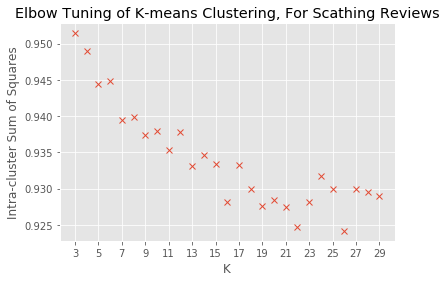

In [79]:
# Plot graph to find the elbow
# Final working value: 11
plt.title("Elbow Tuning of K-means Clustering, For Scathing Reviews")
plt.xlabel("K")
plt.xticks(range(3, 30, 2))
plt.ylabel("Intra-cluster Sum of Squares")
plt.plot(range(3, 30, 1), tuning_bad_ss, "x")

In [80]:
# Obtain the feature index-to-word mapping
index_to_word_bad = {index:word for word,index in vectorizer_bad.vocabulary_.items()}

kmeans_bad = MiniBatchKMeans(n_clusters=11, max_iter=5000, random_state=42)
kmeans_bad.fit(X_bad)
print_top_features(kmeans_bad.cluster_centers_, index_to_word_bad, n=10)

Top words from cluster 0
['pho', 'place', 'broth', 'soup', 'food', 'like', 'service', 'good', 'ordered', 'rolls']
Top words from cluster 1
['waited', 'dog', 'minutes', 'service', 'one', '10', 'would', 'even', 'bar', 'walked']
Top words from cluster 2
['us', 'table', 'minutes', 'came', 'server', 'food', 'asked', 'said', 'order', 'service']
Top words from cluster 3
['lunch', 'food', 'place', 'went', 'today', 'minutes', 'service', 'time', 'eat', 'back']
Top words from cluster 4
['chicken', 'food', 'ordered', 'rice', 'fried', 'like', 'good', 'salad', 'got', 'place']
Top words from cluster 5
['food', 'place', 'like', 'good', 'go', 'worst', 'ever', 'one', 'would', 'service']
Top words from cluster 6
['order', 'drive', 'thru', 'time', 'get', 'said', 'food', 'minutes', 'called', 'back']
Top words from cluster 7
['pizza', 'order', 'ordered', 'delivery', 'cheese', 'place', 'pizzas', 'called', 'never', 'crust']
Top words from cluster 8
['meat', 'lobster', 'ordered', 'steak', 'salad', 'like', 'goo

In [81]:
# Print sample scathing reviews

for cid in range(0, len(kmeans_bad.cluster_centers_) ):
    # Get boolean mask for reviews corresponding to each cid
    mask = (kmeans_bad.labels_ == cid)
    
    # Obtain the first review for each cid (an arbitary choice)
    review_index = np.nonzero(mask)[0][0]
    
    print("\nSample review from cluster {}".format(cid))
    print(documents_bad.iloc[review_index])


Sample review from cluster 0
Pho Saigon 8 was my choice of restaurant every time I visited Las Vegas. However, I was very disappointed with the quality of food and the services at my recent visit. All 4 dishes that each person in our party of four ordered did not meet our expectation. Pho bo was just ok. Banh tam bi and com ga quay were bland. Hu tieu tom cua had very strong smell of seafood.

Sample review from cluster 1
I was really excited for this place till we ate here, its way overpriced we waited over 20 minutes for a drink and at least another 30 minutes for our food that had absolutely no flavor, and it wasnt busy at the time either.

Sample review from cluster 2
I was so excited to try this restaurant because we need some real Mexican food here in Las Vegas!  I was finally able to go last night and I was so disappointed!   When we sat down at our table it took 10 mins for the waitress to come over for our drink order then another 10 for the girl to come and bring us some chi

In [82]:
# Again, inspect whethere there are clusters with only a few reviews
pd.Series(kmeans_bad.labels_).value_counts()

5     4884
10    2246
2     1815
6     1641
8      916
4      850
7      723
9      594
1      302
3      268
0      198
dtype: int64

### Conclusion from Clustering the Scathing Reviews

The individual top words captured by each cluster do correspond to words found in reviews. However, it is only by looking at the reviews themselves can we understand the top words in context. Put differently: K-means clustering at the single-word+Tf-idf level, by itself, isn't very helpful at uncovering themes of complaints. (Because we ended up reading some reviews in full anyway.)

A few observations after reading the sample reviews:
1. The most common complaint seems to revolve around the hygiene/taste of food, followed by rude service and the occasional long wait-times for food. 
2. "Rude" can refer to the, or say, asking customers to leave when there was no convincing reason to say so.

Possible method of improvement:
- Explore using ngrams. Instead of tokenizing text solely by space separation, consider 2-3 words together as one unit. Perhaps longer phrases would give us enough context at first glance.